# Criar nosso primeiro CATALOG

In [0]:
%sql
CREATE CATALOG IF NOT EXISTS demo_catalog
COMMENT 'Catálogo de demonstração criado para o workshop de Unity Catalog';


#Criar um SCHEMA (database) no catálogo

In [0]:
%sql
CREATE SCHEMA IF NOT EXISTS demo_catalog.bronze
COMMENT 'Schema Bronze para dados brutos e heterogêneos';


In [0]:
%sql
CREATE SCHEMA IF NOT EXISTS demo_catalog.silver
COMMENT 'Schema Silver para dados tratados';


In [0]:
%sql
CREATE SCHEMA IF NOT EXISTS demo_catalog.gold
COMMENT 'Schema Gold para dados que serão utilizados por negócio';

# Criar uma TABELA

In [0]:
%sql
CREATE TABLE demo_catalog.bronze.sales (
  sale_id INT,
  product STRING,
  quantity INT,
  price DOUBLE,
  sale_date DATE
)
USING DELTA
COMMENT 'Tabela de vendas brutas no formato Delta';


In [0]:
%sql
SELECT * FROM demo_catalog.bronze.sales

sale_id,product,quantity,price,sale_date
1,Notebook Dell,1,5500.0,2025-10-01
2,Notebook Dell,2,5200.0,2025-10-02
3,Notebook Dell,1,5300.0,2025-10-03
4,Notebook Dell,3,5400.0,2025-10-04
5,Notebook Dell,1,5600.0,2025-10-05
6,"Monitor LG 27""",2,1200.0,2025-10-06
7,"Monitor LG 27""",1,1150.0,2025-10-07
8,"Monitor LG 27""",3,1180.0,2025-10-08
9,"Monitor LG 27""",2,1220.0,2025-10-09
10,"Monitor LG 27""",1,1250.0,2025-10-10


In [0]:
%sql
INSERT INTO demo_catalog.bronze.sales (sale_id, product, quantity, price, sale_date)
VALUES
  -- Grupo 1: Notebook
  (1, 'Notebook Dell', 1, 5500.00, DATE'2025-10-01'),
  (2, 'Notebook Dell', 2, 5200.00, DATE'2025-10-02'),
  (3, 'Notebook Dell', 1, 5300.00, DATE'2025-10-03'),
  (4, 'Notebook Dell', 3, 5400.00, DATE'2025-10-04'),
  (5, 'Notebook Dell', 1, 5600.00, DATE'2025-10-05'),

  -- Grupo 2: Monitor
  (6, 'Monitor LG 27"', 2, 1200.00, DATE'2025-10-06'),
  (7, 'Monitor LG 27"', 1, 1150.00, DATE'2025-10-07'),
  (8, 'Monitor LG 27"', 3, 1180.00, DATE'2025-10-08'),
  (9, 'Monitor LG 27"', 2, 1220.00, DATE'2025-10-09'),
  (10, 'Monitor LG 27"', 1, 1250.00, DATE'2025-10-10'),

  -- Grupo 3: Headset
  (11, 'Headset HyperX', 2, 600.00, DATE'2025-10-11'),
  (12, 'Headset HyperX', 1, 590.00, DATE'2025-10-12'),
  (13, 'Headset HyperX', 3, 620.00, DATE'2025-10-13'),
  (14, 'Headset HyperX', 2, 610.00, DATE'2025-10-14'),
  (15, 'Headset HyperX', 1, 630.00, DATE'2025-10-15');


num_affected_rows,num_inserted_rows
15,15


### USING DELTA é o formato padrão gerenciado pelo Unity Catalog.
### Você pode inserir dados normalmente com INSERT ou COPY INTO.

product,total_sold,revenue
Notebook Dell,8,43000
"Monitor LG 27""",9,10780
Headset HyperX,9,5500


In [0]:
%sql
CREATE OR REPLACE VIEW demo_catalog.bronze.vw_sales_summary AS
SELECT
  product,
  SUM(quantity) AS total_sold,
  ROUND(SUM(quantity * price), 2) AS revenue
FROM demo_catalog.bronze.sales
GROUP BY product;


In [0]:
%sql
SELECT * FROM Demo_catalog.bronze.vw_sales_summary

# Criar um VOLUME (arquivos)

In [0]:
%sql
CREATE VOLUME demo_catalog.bronze.raw_files
COMMENT 'Volume para arquivos brutos de ingestão inicial';

## Visualizar a imagem e adicionar imagems

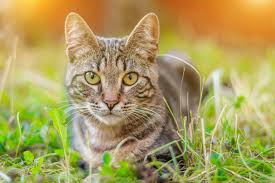

In [0]:
from PIL import Image

path = "/Volumes/demo_catalog/bronze/raw_files/gato.jpeg"
img = Image.open(path)
display(img)


In [0]:
print(img.format, img.size, img.mode)


JPEG (275, 183) RGB


In [0]:
%pip install torch torchvision

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
import torch
from torchvision import models, transforms
import urllib.request

# Carregar rótulos do ImageNet
labels_url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
imagenet_labels = urllib.request.urlopen(labels_url).read().decode("utf-8").splitlines()

# Pré-processamento padrão do ResNet
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Carregar imagem e preparar tensor
input_tensor = preprocess(Image.open(path).convert("RGB")).unsqueeze(0)

# Modelo pré-treinado
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.eval()

# Inferência
with torch.no_grad():
    logits = model(input_tensor)
    probs = torch.nn.functional.softmax(logits, dim=1)[0]

topk = torch.topk(probs, k=5)
top5 = [(imagenet_labels[idx], float(probs[idx])) for idx in topk.indices.tolist()]
top5


42.0%

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/spark-c6d50c40-a376-41f2-bf77-56/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100.0%


[('tiger cat', 0.3580496907234192),
 ('tabby', 0.3475533127784729),
 ('Egyptian cat', 0.2690144181251526),
 ('lynx', 0.009170976467430592),
 ('plastic bag', 0.0034825552720576525)]

In [0]:
from pyspark.sql import Row
import json

prediction = Row(
    file_path = path,
    top1_label = top5[0][0],
    top1_prob  = top5[0][1],
    top5_json  = json.dumps(top5)
)

spark.createDataFrame([prediction]) \
     .write.mode("append") \
     .saveAsTable("demo_catalog.bronze.image_predictions")


In [0]:
%sql
SELECT * FROM demo_catalog.bronze.image_predictions



file_path,top1_label,top1_prob,top5_json
/Volumes/demo_catalog/bronze/raw_files/gato.jpeg,tiger cat,0.3580496907234192,"[[""tiger cat"", 0.3580496907234192], [""tabby"", 0.3475533127784729], [""Egyptian cat"", 0.2690144181251526], [""lynx"", 0.009170976467430592], [""plastic bag"", 0.0034825552720576525]]"


## Trabalhar com arquivos csv, json e parquet

### Ler e exibir os dados diretamente

In [0]:
# === Parquet ===
df_parquet = spark.read.parquet("/Volumes/demo_catalog/bronze/raw_files/dados.parquet")
print("🟢 PARQUET:")
df_parquet.show(truncate=False)

# === CSV ===
df_csv = (
    spark.read
    .option("header", True)
    .option("inferSchema", True)
    .csv("/Volumes/demo_catalog/bronze/raw_files/dados.csv")
)
print("🟢 CSV:")
df_csv.show(truncate=False)

# === JSON ===
df_json = spark.read.json("/Volumes/demo_catalog/bronze/raw_files/dados.json")
print("🟢 JSON:")
df_json.show(truncate=False)


🟢 PARQUET:
+---+--------+-----+--------------+--------+
|id |nome    |idade|cidade        |salario |
+---+--------+-----+--------------+--------+
|1  |Luciano |34   |São Paulo     |8500.5  |
|2  |Fernanda|29   |Rio de Janeiro|9200.0  |
|3  |Marcos  |41   |Belo Horizonte|10500.75|
|4  |Ana     |25   |Curitiba      |7000.0  |
|5  |Pedro   |38   |Salvador      |9700.25 |
+---+--------+-----+--------------+--------+

🟢 CSV:
+---+--------+-----+--------------+--------+
|id |nome    |idade|cidade        |salario |
+---+--------+-----+--------------+--------+
|1  |Luciano |34   |São Paulo     |8500.5  |
|2  |Fernanda|29   |Rio de Janeiro|9200.0  |
|3  |Marcos  |41   |Belo Horizonte|10500.75|
|4  |Ana     |25   |Curitiba      |7000.0  |
|5  |Pedro   |38   |Salvador      |9700.25 |
+---+--------+-----+--------------+--------+

🟢 JSON:
+--------------+---+-----+--------+--------+
|cidade        |id |idade|nome    |salario |
+--------------+---+-----+--------+--------+
|São Paulo     |1  |34   |L

## Fazer queries SQL com o DataFrame API

In [0]:
# Exemplo de SELECT * (todos os dados)
df_parquet.select("*").show()

# Exemplo de SELECT específico
df_parquet.select("id", "nome", "salario").show()

# Exemplo com filtro (WHERE)
df_parquet.filter(df_parquet.salario > 9000).select("nome", "salario").show()


In [0]:
# Exemplo de SELECT * (todos os dados)
df_parquet.select("*").show()

+---+--------+-----+--------------+--------+
| id|    nome|idade|        cidade| salario|
+---+--------+-----+--------------+--------+
|  1| Luciano|   34|     São Paulo|  8500.5|
|  2|Fernanda|   29|Rio de Janeiro|  9200.0|
|  3|  Marcos|   41|Belo Horizonte|10500.75|
|  4|     Ana|   25|      Curitiba|  7000.0|
|  5|   Pedro|   38|      Salvador| 9700.25|
+---+--------+-----+--------------+--------+



In [0]:
# Exemplo de SELECT específico
df_parquet.select("id", "nome", "salario").show()

+---+--------+--------+
| id|    nome| salario|
+---+--------+--------+
|  1| Luciano|  8500.5|
|  2|Fernanda|  9200.0|
|  3|  Marcos|10500.75|
|  4|     Ana|  7000.0|
|  5|   Pedro| 9700.25|
+---+--------+--------+



In [0]:
# Exemplo com filtro (WHERE)
df_parquet.filter(df_parquet.salario > 9000).select("nome", "salario").show()

+--------+--------+
|    nome| salario|
+--------+--------+
|Fernanda|  9200.0|
|  Marcos|10500.75|
|   Pedro| 9700.25|
+--------+--------+



## Podemos salvar em views

In [0]:
# Ler Parquet
df_parquet = spark.read.parquet("/Volumes/demo_catalog/bronze/raw_files/dados.parquet")
df_parquet.createOrReplaceTempView("vw_parquet")

# Ler CSV
df_csv = (
    spark.read
    .option("header", True)
    .option("inferSchema", True)
    .csv("/Volumes/demo_catalog/bronze/raw_files/dados.csv")
)
df_csv.createOrReplaceTempView("vw_csv")

# Ler JSON
df_json = spark.read.json("/Volumes/demo_catalog/bronze/raw_files/dados.json")
df_json.createOrReplaceTempView("vw_json")


In [0]:
%sql
SELECT * FROM vw_parquet;

id,nome,idade,cidade,salario
1,Luciano,34,São Paulo,8500.5
2,Fernanda,29,Rio de Janeiro,9200.0
3,Marcos,41,Belo Horizonte,10500.75
4,Ana,25,Curitiba,7000.0
5,Pedro,38,Salvador,9700.25


In [0]:
%sql
-- CSV
SELECT * FROM vw_csv;


id,nome,idade,cidade,salario
1,Luciano,34,São Paulo,8500.5
2,Fernanda,29,Rio de Janeiro,9200.0
3,Marcos,41,Belo Horizonte,10500.75
4,Ana,25,Curitiba,7000.0
5,Pedro,38,Salvador,9700.25


In [0]:
%sql
-- JSON
SELECT * FROM vw_json;

cidade,id,idade,nome,salario
São Paulo,1,34,Luciano,8500.5
Rio de Janeiro,2,29,Fernanda,9200.0
Belo Horizonte,3,41,Marcos,10500.75
Curitiba,4,25,Ana,7000.0
Salvador,5,38,Pedro,9700.25


## Criar uma função SQL no Unity Catalog

#### Ideal quando a lógica é simples (ex: cálculo, concatenação, formatação).

In [0]:
%sql
CREATE OR REPLACE FUNCTION demo_catalog.bronze.calc_bonus(salario DOUBLE, percentual DOUBLE)
RETURNS DOUBLE
COMMENT 'Calcula bônus de acordo com o percentual informado'
RETURN salario * (percentual / 100);

### Usar a função em uma query

In [0]:
%sql
USE CATALOG demo_catalog;
USE SCHEMA bronze;

In [0]:
%sql
SELECT
  nome,
  salario,
  calc_bonus(salario, 10) AS bonus_10
FROM vw_parquet;


nome,salario,bonus_10
Luciano,8500.5,850.0500000000001
Fernanda,9200.0,920.0
Marcos,10500.75,1050.075
Ana,7000.0,700.0
Pedro,9700.25,970.0250000000001


## Criar um MODEL via mlflow

In [0]:
%sql
-- 1) Garanta que o catálogo e o schema existem
CREATE CATALOG IF NOT EXISTS demo_catalog;
CREATE SCHEMA  IF NOT EXISTS demo_catalog.ml
COMMENT 'Schema para registrar modelos de ML (Unity Catalog)';

In [0]:
# %pip install mlflow scikit-learn --quiet  # se precisar

import pandas as pd
import mlflow, mlflow.sklearn
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from mlflow.models.signature import infer_signature

# === Dados como DataFrame (facilita a signature com nomes de colunas) ===
iris = load_iris(as_frame=True)
X, y = iris.data, iris.target  # X é DataFrame, y é Series
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# === Modelo ===
clf = RandomForestClassifier(n_estimators=50, random_state=42).fit(X_train, y_train)

# === Signature + input_example (obrigatórios para UC Models) ===
input_example = X_train.iloc[:3]
signature = infer_signature(X_train, clf.predict(X_train))

# === Registrar no Unity Catalog ===
mlflow.set_registry_uri("databricks-uc")

with mlflow.start_run():
    mlflow.sklearn.log_model(
        sk_model=clf,
        artifact_path="model",
        registered_model_name="demo_catalog.ml.iris_model",  # <catalog>.<schema>.<name>
        signature=signature,
        input_example=input_example
    )

print("✅ Modelo registrado com signature: demo_catalog.ml.iris_model")


Successfully registered model 'demo_catalog.ml.iris_model'.


✅ Modelo registrado com signature: demo_catalog.ml.iris_model


Created version '1' of model 'demo_catalog.ml.iris_model'.


## Dropar tabelas

In [0]:
%sql
DROP TABLE demo_catalog.bronze.sales

In [0]:
%sql
SELECT * FROM demo_catalog.bronze.sales

sale_id,product,quantity,price,sale_date
1,Notebook Dell,1,5500.0,2025-10-01
2,Notebook Dell,2,5200.0,2025-10-02
3,Notebook Dell,1,5300.0,2025-10-03
4,Notebook Dell,3,5400.0,2025-10-04
5,Notebook Dell,1,5600.0,2025-10-05
6,"Monitor LG 27""",2,1200.0,2025-10-06
7,"Monitor LG 27""",1,1150.0,2025-10-07
8,"Monitor LG 27""",3,1180.0,2025-10-08
9,"Monitor LG 27""",2,1220.0,2025-10-09
10,"Monitor LG 27""",1,1250.0,2025-10-10


In [0]:
%sql
UNDROP TABLE demo_catalog.bronze.sales

## Time Travel — voltando a versões antigas

In [0]:
%sql
DESCRIBE HISTORY demo_catalog.bronze.sales;


version,timestamp,userId,userName,operation,operationParameters,job,notebook,clusterId,readVersion,isolationLevel,isBlindAppend,operationMetrics,userMetadata,engineInfo
3,2025-10-29T09:52:54.000Z,72402393859838,databrickstrilha@gmail.com,RESTORE,"Map(version -> 1, timestamp -> null)",null,List(3513138582187969),1029-085536-q3ipkjoo-v2n,2,Serializable,false,"Map(numRestoredFiles -> 0, removedFilesSize -> 1758, numRemovedFiles -> 1, restoredFilesSize -> 0, numDeletionVectorsAdded -> 0, numDeletionVectorsRemoved -> 0, numOfFilesAfterRestore -> 1, tableSizeAfterRestore -> 1758)",null,Databricks-Runtime/17.2.x-aarch64-photon-scala2.13
2,2025-10-29T09:51:09.000Z,72402393859838,databrickstrilha@gmail.com,WRITE,"Map(mode -> Append, statsOnLoad -> true, partitionBy -> [])",null,List(3513138582187969),1029-085536-q3ipkjoo-v2n,1,WriteSerializable,true,"Map(numFiles -> 1, numOutputRows -> 15, numOutputBytes -> 1758)",null,Databricks-Runtime/17.2.x-aarch64-photon-scala2.13
1,2025-10-29T09:10:14.000Z,72402393859838,databrickstrilha@gmail.com,WRITE,"Map(mode -> Append, statsOnLoad -> true, partitionBy -> [])",null,List(3513138582187969),1029-085536-q3ipkjoo-v2n,0,WriteSerializable,true,"Map(numFiles -> 1, numOutputRows -> 15, numOutputBytes -> 1758)",null,Databricks-Runtime/17.2.x-aarch64-photon-scala2.13
0,2025-10-29T09:00:46.000Z,72402393859838,databrickstrilha@gmail.com,CREATE TABLE,"Map(partitionBy -> [], clusterBy -> [], description -> Tabela de vendas brutas no formato Delta, isManaged -> true, properties -> {""delta.parquet.compression.codec"":""zstd"",""delta.enableDeletionVectors"":""true"",""delta.enableRowTracking"":""true"",""delta.rowTracking.materializedRowCommitVersionColumnName"":""_row-commit-version-col-48c830f9-572f-4641-b91a-031099f8d004"",""delta.rowTracking.materializedRowIdColumnName"":""_row-id-col-7fe1d088-5cc5-4ce2-899e-dd9c4370d07f""}, statsOnLoad -> false)",null,List(3513138582187969),1029-085536-q3ipkjoo-v2n,null,WriteSerializable,true,Map(),null,Databricks-Runtime/17.2.x-aarch64-photon-scala2.13


## Consultar uma versão anterior

In [0]:
%sql
SELECT count(*) FROM demo_catalog.bronze.sales


count(*)
15


## Restaurar para uma versão anterior

In [0]:
%sql
RESTORE TABLE demo_catalog.bronze.sales TO VERSION AS OF 1;


table_size_after_restore,num_of_files_after_restore,num_removed_files,num_restored_files,removed_files_size,restored_files_size
1758,1,1,0,1758,0


In [0]:
%sql
DESCRIBE HISTORY demo_catalog.bronze.sales;
